In [1]:
import torch
import torch.nn as nn
from glob import glob
import os

In [2]:
# Experiment configs
LOSS_FUNCTION = "NLL" # Supported values: "cross_entropy", "NLL"
REMOTE_DATASET_PATH = "https://github.com/rpharale/deep_learning/raw/main/notebooks/nlp/data/names.zip"
LOCAL_DATASET_DIR = "./data/"
DATASET_DIR_NAME = os.path.basename(REMOTE_DATASET_PATH).split('.')[0]
TRAIN_DATA_DIR = f'{LOCAL_DATASET_DIR}/{DATASET_DIR_NAME}/*.txt'
print(f"DATASET_DIR_NAME={DATASET_DIR_NAME}")
print(f"TRAIN_DATA_DIR={TRAIN_DATA_DIR}")

DATASET_DIR_NAME=names
TRAIN_DATA_DIR=./data//names/*.txt


In [3]:
import wget
os.makedirs(LOCAL_DATASET_DIR, exist_ok=True)
zip_name = os.path.join(LOCAL_DATASET_DIR, os.path.basename(REMOTE_DATASET_PATH))
if not os.path.exists(zip_name):
    zip_name = wget.download(REMOTE_DATASET_PATH, out=LOCAL_DATASET_DIR)
    print(f"Downloaded Zip file at {zip_name}")
else:
    print(f"Zip file already exists at {zip_name}")

Zip file already exists at ./data/names.zip


In [4]:
import zipfile
unzip_path = zip_name.split('.zip')[0]
if not os.path.exists(unzip_path):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATASET_DIR)
    print(f"Extracted dataset at {unzip_path}")
else:
    print(f"Dataset already exists at {unzip_path}")

Dataset already exists at ./data/names


In [5]:
# Function to convert the unicode to ascii. So that we will only have 26 chars in the dataset
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
# Read the data from the file
files = glob(TRAIN_DATA_DIR)
category_lines = {}
all_categories = []
n_categories = None
for file in files:
    names = open(file).read().splitlines()
    names = [unicodeToAscii(name) for name in names]
    category = os.path.basename(file).split('.')[0]
    category_lines[category] = names
    all_categories.append(category)
    #break;

n_categories = len(all_categories)
    
# Print len of data in each category
for k,v in category_lines.items():
    print(f"{k}: {len(v)}")

Czech: 519
German: 724
Arabic: 2000
Japanese: 991
Chinese: 268
Vietnamese: 73
Russian: 9408
French: 277
Irish: 232
English: 3668
Spanish: 298
Greek: 203
Italian: 709
Portuguese: 74
Scottish: 100
Dutch: 297
Korean: 94
Polish: 139


In [7]:
# build names to country dict
names_to_country = {vi: k for k,v in category_lines.items() for vi in v }
print(f"Total size of dataset: {len(names_to_country)}")

Total size of dataset: 17422


In [8]:
# Functions to convert names to tensors

def letterToIndex(ch):
    return all_letters.find(ch)

def letterToTensor(ch):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(ch)] = 1
    return tensor

def lineToTensor(s):
    tensor = torch.zeros(len(s), 1, n_letters)
    for i,ch in enumerate(s):
        tensor[i][0][letterToIndex(ch)] = 1
    return tensor

In [21]:
if 0: # 1 layered RNN model
    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()

            self.hidden_size = hidden_size
            self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
            self.i2o = nn.Linear(input_size + hidden_size, output_size)
            self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, inp, hidden):
            combined = torch.cat((inp, hidden), dim=1)
            hidden = self.i2h(combined)
            out = self.i2o(combined)
            # If loss function is cross_entropy, no need to apply softmax because cross_entropy loss takes raw values as inputs
            if LOSS_FUNCTION == "NLL":
                out = self.softmax(out)
            return out, hidden

        def init_hidden(self):
            return torch.zeros((1, self.hidden_size))

elif 1: # RNN + Linear layers

    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()

            self.hidden_size = hidden_size
            self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
            #self.i2o = nn.Linear(input_size + hidden_size, output_size)
            self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
            self.linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) \
                                          for _ in range(1)])
            self.final_layer = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, inp, hidden):
            combined = torch.cat((inp, hidden), dim=1)
            hidden = self.i2h(combined)
            out = self.i2o(combined)
            for layer in self.linears:
                out = self.relu(out)
                out = layer(out)
            out = self.final_layer(self.relu(out))
            # If loss function is cross_entropy, no need to apply softmax because cross_entropy loss takes raw values as inputs
            if LOSS_FUNCTION == "NLL":
                out = self.softmax(out)
            return out, hidden

        def init_hidden(self):
            return torch.zeros((1, self.hidden_size))

In [22]:
def categoryFromOutput(output):
    topk_vals, topk_idxs = output.topk(1)
    category_idx = topk_idxs.item()
    return all_categories[category_idx], category_idx

In [23]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Skokan
category = Spanish / line = Etxebarria
category = German / line = Lorenz
category = Dutch / line = Kranz
category = Greek / line = Koutsoubos
category = French / line = Lecuyer
category = Korean / line = Cha
category = Russian / line = Batsev
category = Greek / line = Kouches
category = Scottish / line = Hunter


In [24]:
# initialize the network
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
hidden = rnn.init_hidden()
inp = torch.zeros(1, n_letters)
out, hidden = rnn(inp, hidden)
out.shape, len(all_categories)

(torch.Size([1, 18]), 18)

In [25]:
# loss function
if LOSS_FUNCTION == "NLL":
    criterion = nn.NLLLoss()
elif LOSS_FUNCTION == "cross_entropy":
    criterion = nn.CrossEntropyLoss()
#lr = 0.01 #0.005

In [26]:
def get_lr(iter_no):
    if LOSS_FUNCTION == "NLL":
        lr = 0.01 if iter_no <= 50000 else 0.005
    elif LOSS_FUNCTION == "cross_entropy":
        lr = 0.01 if iter_no <= 80000 else 0.005
    
    return lr

In [27]:
# train function
def train(line_tensor, category_tensor, lr):
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data -= p.grad.data * lr
    
    return output, loss.item()

category, line, category_tensor, line_tensor = randomTrainingExample()
train(line_tensor, category_tensor, lr=0.001)

(tensor([[-2.8566, -2.8723, -2.9551, -2.9490, -2.8642, -2.9902, -2.9373, -2.9019,
          -2.8396, -2.8486, -2.8980, -2.8363, -2.8340, -2.8792, -2.9292, -2.8891,
          -2.8852, -2.8780]], grad_fn=<LogSoftmaxBackward0>),
 2.885150909423828)

In [28]:
# Training loop
n_iters = 120000
all_losses = []
plot_every = 100
avg_loss = 0.0
ud = []

for i in range(n_iters):
    lr = get_lr(i)
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor, category_tensor, lr)

    avg_loss += loss
    
    # log update/weights ratio for visualization  
    ud.append([((p.grad * lr).std()/p.data.std()).log10().item() for p in rnn.parameters()])

    if i % 10000 == 0:
        pred_category, pred_category_idx = categoryFromOutput(output)
        correct = '✓' if pred_category == category else f'✗{category}'
        print(f"{i}. Category: {category}, name: {line}, loss: {loss}, avg_loss: {avg_loss/plot_every}, prediction: {pred_category}, {correct}")

    if i % plot_every == 0 and i != 0:
        all_losses.append(avg_loss / plot_every)
        avg_loss = 0.0
        
    #break

0. Category: Greek, name: Fourakis, loss: 2.8444137573242188, avg_loss: 0.028444137573242188, prediction: Italian, ✗Greek
10000. Category: Czech, name: Machacek, loss: 1.7221941947937012, avg_loss: 1.7671421176195146, prediction: Polish, ✗Czech
20000. Category: Japanese, name: Kusuhara, loss: 0.25368547439575195, avg_loss: 1.532636941857636, prediction: Japanese, ✓
30000. Category: Scottish, name: Scott, loss: 3.1037769317626953, avg_loss: 1.425510148629546, prediction: German, ✗Scottish
40000. Category: Dutch, name: Antwerp, loss: 1.546473741531372, avg_loss: 1.3246708664763718, prediction: German, ✗Dutch
50000. Category: Russian, name: Bahlulzade, loss: 3.5863914489746094, avg_loss: 1.5371285287290812, prediction: Japanese, ✗Russian
60000. Category: Arabic, name: Tuma, loss: 0.024142680689692497, avg_loss: 1.0028439455342595, prediction: Arabic, ✓
70000. Category: Greek, name: Varvitsiotes, loss: 0.2804356813430786, avg_loss: 1.0381135703530162, prediction: Greek, ✓
80000. Category: 

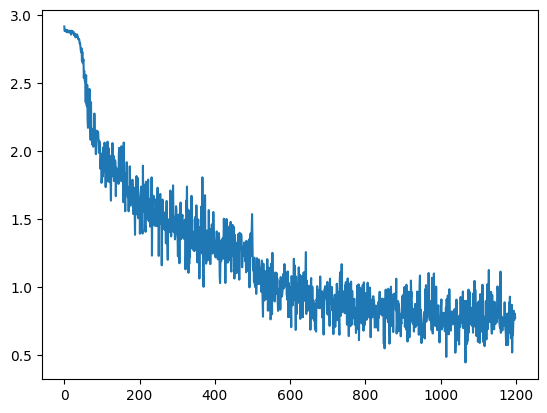

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(len(all_losses)), all_losses);

In [30]:
# Evaluation
n_evals = 10000
confusion_matrix = torch.zeros((n_categories, n_categories))
correct_preds = 0
wrong_preds = 0

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    pred_category, pred_category_idx = categoryFromOutput(output)
    return pred_category, pred_category_idx

for i in range(n_evals):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    _, pred_category_idx = evaluate(line_tensor)
    category_idx = all_categories.index(category)
    confusion_matrix[category_idx][pred_category_idx] += 1
    correct_preds = (correct_preds + 1) if pred_category_idx == category_idx else correct_preds
    wrong_preds = (wrong_preds + 1) if pred_category_idx != category_idx else wrong_preds

# Normalize the rows of confusion matrix
for i in range(n_categories):
    confusion_matrix[i] = confusion_matrix[i] / confusion_matrix[i].sum()

print(f"Num correct predictions: {correct_preds}")
print(f"Num wrong predictions: {wrong_preds}")
print(f"Accuracy: {correct_preds / (correct_preds + wrong_preds) * 100.0:.2f}")
    

Num correct predictions: 7427
Num wrong predictions: 2573
Accuracy: 74.27


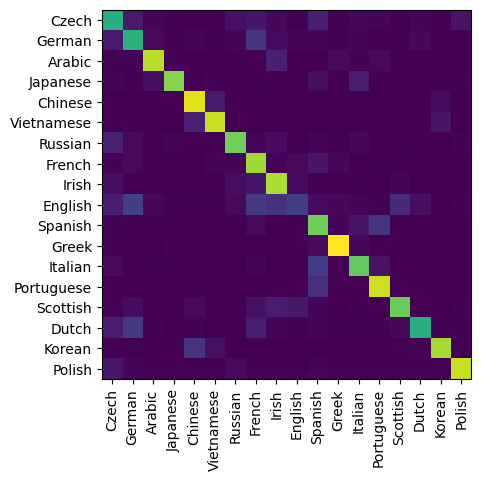

In [31]:
plt.imshow(confusion_matrix.numpy())

# Set up axes
plt.xticks(range(n_categories), all_categories, rotation=90);
plt.yticks(range(n_categories), all_categories);

## Learning rate Inspection:
#### Visualize the update/weights ratio

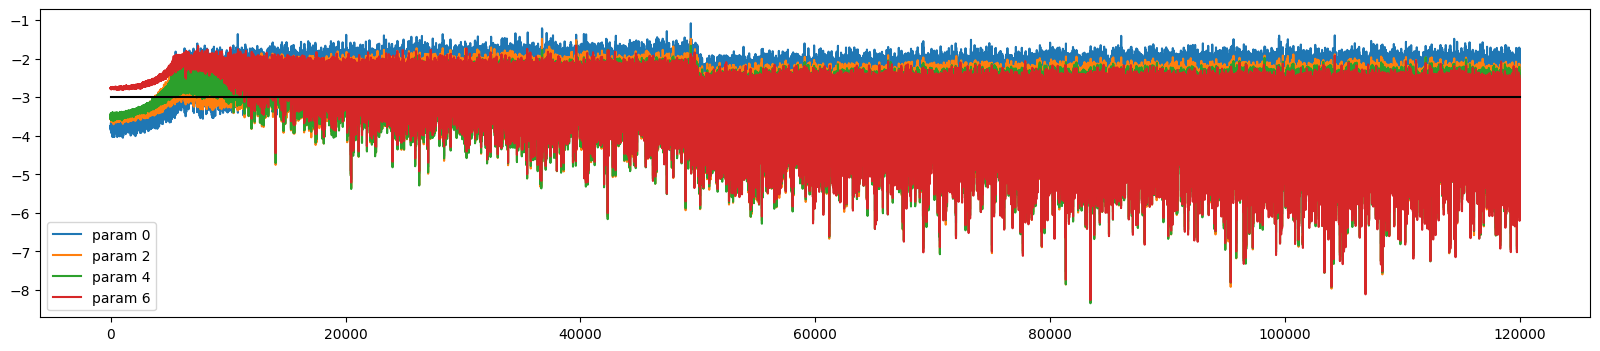

In [32]:
# Visualize the update/weights ratio
# This will help us tune the learning rate
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(rnn.parameters()):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#### Results summary
1) LogSoftmax with NLL loss: \
    -> lr=0.005 \
        Num correct predictions: 5593 \
        Num wrong predictions: 4407 \
        Accuracy: 55.93 \
        \
    -> lr=0.01 if i<=50000 else 0.005 \
        Num correct predictions: 6209 \
        Num wrong predictions: 3791 \
        Accuracy: 62.09 \
        
2) Softmax with CrossEntropyLoss: \
    -> lr = 0.005 \
        Num correct predictions: 5659 \
        Num wrong predictions: 4341 \
        Accuracy: 56.59 \

3) RNN + 1 Linear layer: \
    -> Num correct predictions: 7447 \
       Num wrong predictions: 2553 \
       Accuracy: 74.47 \

4) RNN + 2 Linear layers: \
    -> Num correct predictions: 7934 \
       Num wrong predictions: 2606 \
       Accuracy: 73.94 \

5) RNN + 4 Linear Layers: \
    -> Num correct predictions: 6722 \
       Num wrong predictions: 3278 \
       Accuracy: 67.22 \
    